In [11]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm
from qick import *

In [12]:
from qick.asm_v2 import AveragerProgramV2

In [13]:
import xrfclk
#xrfclk.set_ref_clks(lmk_freq=245.76, lmx_freq=491.52)

In [15]:
from pynq.pl_server.global_state import clear_global_state
clear_global_state()

In [16]:
soc = QickSoc(bitfile='/home/xilinx/jupyter_notebooks/qick/qick_demos/custom/drivers/216_tProc_v8.bit')
soc_cfg = soc
print(soc_cfg)

QICK running on ZCU216, software version 0.2.297

Firmware configuration (built Thu Nov 14 10:01:25 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	9 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_sg_int4_v2 - envelope memory 8192 samples (19.048 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=1720.320 MHz
		DAC tile 1, blk 0 is 0_229, on JHC1
	4:	axis_sg_mixmux8_v1 - envelope memory 0 samples (0.000 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-b

In [17]:
### INITIALIZE SPI DEVICES ###
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/qick/qick_demos/custom/drivers')
from TIDAC80508 import TIDAC80508
tidac = TIDAC80508()

dac_2280 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[0]
dac_2280.SetDACVOP(30000)
dac_2281 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[1]
dac_2281.SetDACVOP(30000)
dac_2282 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[2]
dac_2282.SetDACVOP(30000)
dac_2283 = soc_cfg.usp_rf_data_converter_0.dac_tiles[0].blocks[3]
dac_2283.SetDACVOP(30000)
dac_2290 = soc_cfg.usp_rf_data_converter_0.dac_tiles[1].blocks[0]
dac_2290.SetDACVOP(30000)
dac_2292 = soc_cfg.usp_rf_data_converter_0.dac_tiles[1].blocks[2]
dac_2292.SetDACVOP(5000)
dac_2230 = soc_cfg.usp_rf_data_converter_0.dac_tiles[2].blocks[0]
dac_2230.SetDACVOP(30000)
dac_2231 = soc_cfg.usp_rf_data_converter_0.dac_tiles[2].blocks[1]
dac_2231.SetDACVOP(30000)
dac_2232 = soc_cfg.usp_rf_data_converter_0.dac_tiles[2].blocks[2]
dac_2232.SetDACVOP(30000)

soc_cfg.usp_rf_data_converter_0.mts_dac_config.RefTile = 2
soc_cfg.usp_rf_data_converter_0.mts_dac_config.Tiles = 0b0011
soc_cfg.usp_rf_data_converter_0.mts_dac_config.SysRef_Enable = 1
soc_cfg.usp_rf_data_converter_0.mts_dac_config.Target_Latency = -1
soc_cfg.usp_rf_data_converter_0.mts_dac()

def reset_bias():
    tidac.set_bias(channel_cfg["DAC_bias"][0], bias_value=0)
    tidac.set_bias(channel_cfg["DAC_bias"][1], bias_value=0)
    tidac.set_bias(channel_cfg["DAC_bias"][2], bias_value=0)
    tidac.set_bias(channel_cfg["DAC_bias"][3], bias_value=0)

In [18]:
### DEFINE INPUTS AND OUTPUTS ###

DC_FLUX     = [5,2,6,7,4]
RF_FLUX     = [None,0,None,2,None]
DRIVE       = [5,6,7,8,3]
PROBE_CH    = 4
FEEDBACK_CH = [0,1,2,3,4] #ADC
MAX_GAIN    = 32766  
TOF         = 350

### FLUX DEPENDENCE RESONATOR SPECTROSCOPY

In [19]:
class ResonatorFluxDependanceProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        cfg=self.cfg        
        probe_ch    = cfg["probe_ch"]        
        feedback_ch = cfg["feedback_ch"]        
        ro_pulse_shape  = cfg["ro_pulse_shape"]
        self.declare_gen(ch=probe_ch, nqz=cfg["probe_ch_nqz"], ro_ch=feedback_ch[0], mux_freqs=cfg['ro_pulse_frequency'], mux_gains=cfg['ro_pulse_gain'], mux_phases=cfg['pulse_phases'], mixer_freq=cfg['mixer_freq'])        
        self.add_pulse(ch=probe_ch, name="mymux", style=ro_pulse_shape, length=cfg["ro_pulse_length"]/1000, mask=[0,1,2,3,4])         
        for iCh, ch in enumerate(feedback_ch):
            self.declare_readout(ch=ch, length = cfg['acquisition_length']/1000, freq=cfg['acquisition_frequency'][iCh], gen_ch=probe_ch)
    
    def _body(self, cfg):
        self.trigger(ros=cfg['feedback_ch'], t=cfg['delay_before_acquisition']/1000)
        self.pulse(ch=cfg['probe_ch'], name="mymux", t=cfg["ro_pulse_start"]/1000)

In [20]:
channel_cfg = { "DAC_bias"      : DC_FLUX,
                "probe_ch"      : PROBE_CH,
                "probe_ch_nqz"  : 2,
                "feedback_ch"   : FEEDBACK_CH,
}

flux_cfg = {    "q1_sweetspot": 0.05, # update
                "q2_sweetspot": 0.05, # update
                "q3_sweetspot": 0.05, # update
                "q4_sweetspot": 0.05, # update
                "q5_sweetspot": 0.05, # update
}

readout_cfg={   "ro_pulse_start": 0,       # [ns]
                "ro_pulse_gain" : [0.5, 0.5, 0.5, 0.5, 0.5],
                "pulse_phases":   [0,0,0,0,0],
                "mixer_freq": 7000,
                "ro_pulse_length": 3000,   # [ns]
                "ro_pulse_shape": "const", # rectangular
                "ro_pulse_frequency"    : [7431.637, 7511.618, 7549.002, 7584.501, 7611.202],
                "freq_original"         : [7431.637, 7511.618, 7549.002, 7584.501, 7611.202],
                "acquisition_frequency" : [7431.637, 7511.618, 7549.002, 7584.501, 7611.202],
                "acquisition_length": 3500,      # [ns]
                "delay_before_acquisition": TOF, # missing lags[ns]
                "reps": 100,                     # Fixed
                "soft_avgs": 1,                  # [ns],
                "relaxation_time": 10000}        # [ns]
"""
[7431.637, 7511.618, 7549.002, 7584.501, 7611.202],
"""

'\n[7431.637, 7511.618, 7549.002, 7584.501, 7611.202],\n'

In [21]:
def run_resonator_flux_dependence(gain_range):
    fig = go.Figure()
    experiment_points = 101
    results_matrix = np.zeros((len(gain_range), 5*experiment_points))
    for idx, gain in enumerate(tqdm(gain_range)):
        tidac.set_bias(channel_cfg["DAC_bias"][0], bias_value=gain+flux_cfg["q1_sweetspot"])
        tidac.set_bias(channel_cfg["DAC_bias"][1], bias_value=gain+flux_cfg["q2_sweetspot"])
        tidac.set_bias(channel_cfg["DAC_bias"][2], bias_value=gain+flux_cfg["q3_sweetspot"])
        tidac.set_bias(channel_cfg["DAC_bias"][3], bias_value=gain+flux_cfg["q4_sweetspot"])
        tidac.set_bias(channel_cfg["DAC_bias"][4], bias_value=gain+flux_cfg["q5_sweetspot"])
        frequency_range = np.linspace(-2, 2, experiment_points)
        results=[]
        for frequency in frequency_range:
            readout_cfg["ro_pulse_frequency"][0]    = frequency + readout_cfg["freq_original"][0]
            readout_cfg["acquisition_frequency"][0] = frequency + readout_cfg["freq_original"][0]
            readout_cfg["ro_pulse_frequency"][1]    = frequency + readout_cfg["freq_original"][1]
            readout_cfg["acquisition_frequency"][1] = frequency + readout_cfg["freq_original"][1]
            readout_cfg["ro_pulse_frequency"][2]    = frequency + readout_cfg["freq_original"][2]
            readout_cfg["acquisition_frequency"][2] = frequency + readout_cfg["freq_original"][2]
            readout_cfg["ro_pulse_frequency"][3]    = frequency + readout_cfg["freq_original"][3]
            readout_cfg["acquisition_frequency"][3] = frequency + readout_cfg["freq_original"][3]  
            readout_cfg["ro_pulse_frequency"][4]    = frequency + readout_cfg["freq_original"][4]
            readout_cfg["acquisition_frequency"][4] = frequency + readout_cfg["freq_original"][4]  
            program_cfg = {**channel_cfg,**readout_cfg} 
            program = ResonatorFluxDependanceProgram(soccfg=soc_cfg, reps=readout_cfg["reps"], final_delay=10, cfg=program_cfg)
            results.append(program.acquire(soc, start_src="internal", progress=False))
        results = np.transpose(results)
        results_matrix[idx, 0*experiment_points:1*experiment_points] = np.abs(results[0][0][0] + 1j*results[1][0][0])
        results_matrix[idx, 1*experiment_points:2*experiment_points] = np.abs(results[0][0][1] + 1j*results[1][0][1]) 
        results_matrix[idx, 2*experiment_points:3*experiment_points] = np.abs(results[0][0][2] + 1j*results[1][0][2]) 
        results_matrix[idx, 3*experiment_points:4*experiment_points] = np.abs(results[0][0][3] + 1j*results[1][0][3]) 
        results_matrix[idx, 4*experiment_points:5*experiment_points] = np.abs(results[0][0][4] + 1j*results[1][0][4]) 
    print(program)
    reset_bias()
    cf = np.concatenate((frequency_range+readout_cfg["freq_original"][0], frequency_range+readout_cfg["freq_original"][1], frequency_range+readout_cfg["freq_original"][2], frequency_range+readout_cfg["freq_original"][3], frequency_range+readout_cfg["freq_original"][4]))
    #print(cf)
    fig.add_trace(go.Heatmap(z=results_matrix, x=cf, y=gain_range, colorscale='Viridis', colorbar=dict(title='Signal Magnitude [a.u.]')))
    fig.update_layout(title='Resonator Spectroscopy Flux', height = 350, width = 700)
    fig.show()

  0%|          | 0/101 [00:00<?, ?it/s]The readout at 7610.722 MHz may see some crosstalk from the tone at 7584.021 MHz.
The readout at 7610.762 MHz may see some crosstalk from the tone at 7584.061 MHz.
The readout at 7610.802 MHz may see some crosstalk from the tone at 7584.101 MHz.
The readout at 7610.842 MHz may see some crosstalk from the tone at 7584.141 MHz.
The readout at 7610.882 MHz may see some crosstalk from the tone at 7584.181 MHz.
The readout at 7610.922 MHz may see some crosstalk from the tone at 7584.221 MHz.
The readout at 7610.962 MHz may see some crosstalk from the tone at 7584.261 MHz.
The readout at 7611.002 MHz may see some crosstalk from the tone at 7584.301 MHz.
The readout at 7611.042 MHz may see some crosstalk from the tone at 7584.341 MHz.
The readout at 7611.082 MHz may see some crosstalk from the tone at 7584.381 MHz.
The readout at 7611.122 MHz may see some crosstalk from the tone at 7584.421 MHz.
The readout at 7611.162 MHz may see some crosstalk from the

macros:
	WriteReg(dst='s_core_w1', src=0)
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff43a83bb0>}, t_regs={'t': 430})
	OpenLoop(n=100, name='reps')
	Trigger(ros=[0, 1, 2, 3, 4], pins=[], t=0.35, width=0.023251488095238096, ddr4=False, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff43a82230>, 'width': <qick.asm_v2.QickParam object at 0xffff43a83910>}, t_regs={'t': 151, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={6, 7, 12, 13, 14})
	Pulse(ch=4, name='mymux', t=0.0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff43a83ca0>}, t_regs={'t': 0})
	Wait(t=0, auto=True, gens=False, ros=True, tag=None, no_warn=True, t_params={'t': <qick.asm_v2.QickParam object at 0xffff43a81750>}, t_regs={'t': 1651})
	Delay(t=10, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff43a80e20>}, t_regs={'t': 5952})
	IncReg(dst='s_core_w1', src=1)
	

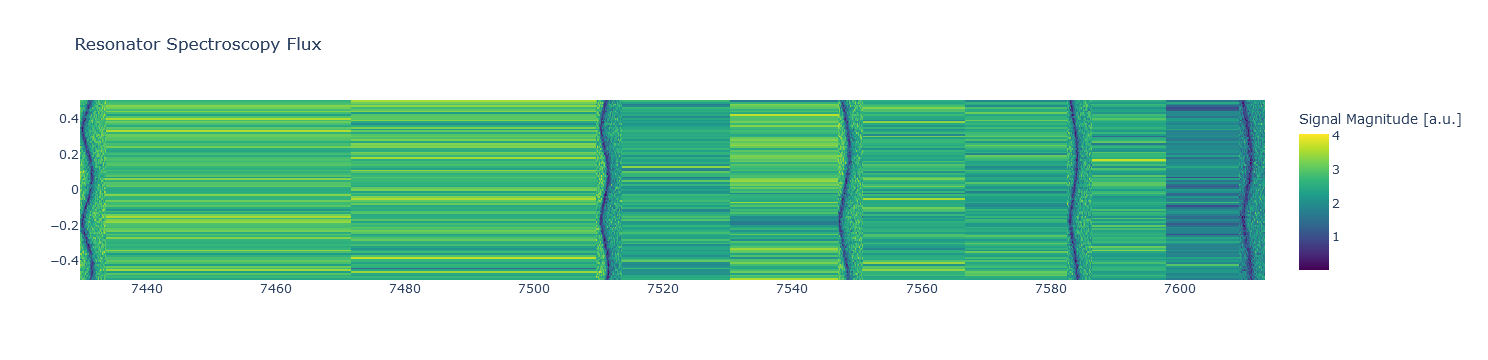

In [22]:
r = run_resonator_flux_dependence(gain_range=np.linspace(-.5, .5, 101))